In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from torchvision.datasets import VOCSegmentation
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from torch import nn
from torch import optim
from skimage.segmentation import mark_boundaries
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

**Installing pytorch segmentaion module**

In [2]:
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 3.5 MB/s 
     |████████████████████████████████| 58 kB 5.9 MB/s 
     |████████████████████████████████| 376 kB 51.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=2cdd5e566ffa7a771edbe9ef344c5dfa67078dfd1c4c5f418018bb69b550e365
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=42287c0b8b701d8fd010f93cb651670acbc09d1f1eecb944288d965866109744
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
class Our_Dataset(Dataset):
  def __init__(self, Image_dir, Mask_dir, transform =None):
    self.image_dir = Image_dir
    self.mask_dir = Mask_dir
    self.transform = transform
    self.images = os.listdir(Image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.images[index])
    img = Image.open(img_path).convert('RGB')
    mask = Image.open(mask_path)

    if self.transform is not None:
      augmented = self.transform(image = np.array(img), mask = np.array(mask))
      img = augmented['image']
      mask = augmented['mask']
      mask[mask>11] = 0

      img = to_tensor(img)
      mask = torch.from_numpy(mask).type(torch.long)

    return img, mask



In [5]:
Train_image_dir = '/content/gdrive/MyDrive/dataset1/images_prepped_train'
Train_mask_dir = '/content/gdrive/MyDrive/dataset1/annotations_prepped_train'
Val_image_dir = '/content/gdrive/MyDrive/dataset1/images_prepped_test'
Val_mask_dir = '/content/gdrive/MyDrive/dataset1/annotations_prepped_test'

**Data Augmentation**

In [6]:
mean = [0.0, 0.0, 0.0]
std = [1.0, 1.0, 1.0]

In [7]:
from albumentations.augmentations.transforms import Normalize
Train_transform = A.Compose(
    [
        A.Resize(height=480, width=384),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Normalize(
            mean,
            std,
            max_pixel_value=255.0,
        ),
    ],
)

Val_transform = A.Compose(
    [
        A.Resize(height=480, width=384),
        A.Normalize(
            mean,
            std,
            max_pixel_value=255.0,
        ),
    ],
)

In [8]:
Train_data=Our_Dataset( Image_dir=Train_image_dir,Mask_dir=Train_mask_dir, transform=Train_transform)
Val_data=Our_Dataset( Image_dir=Val_image_dir,Mask_dir=Val_mask_dir, transform=Val_transform)

In [9]:
# Using matplotlib 'inline' backend, matplotlib graphs will be included in the notebook
%matplotlib inline
np.random.seed(0)
num_class = 11
COLORS = np.random.randint(0, 2 , size = (num_class+1, 3), dtype='uint8')

**Uing Helper Function to visualize Image and Mask**

In [10]:
def show_img(img, target):
    if torch.is_tensor(img):
      img=to_pil_image(img)
      target=target.numpy()
    for ll in range(num_class):
      mask=(target==ll)
      img=mark_boundaries(np.array(img),mask,outline_color=COLORS[ll],color=COLORS[ll])
    plt.imshow(img)

def re_normalize (x, mean = [0.0, 0.0, 0.0], std= [1.0, 1.0, 1.0]):
   x_r= x.clone()
   for i, (mean_i, std_i) in enumerate(zip(mean, std)):
     x_r [i] *= std_i
     x_r [i] += mean_i
     return x_r

In [11]:
img, mask = Train_data[13]

Data Loader

In [12]:
train_data = DataLoader(Train_data, batch_size=4, shuffle=True)
validation_data = DataLoader(Val_data, batch_size=8, shuffle=False)

# **ResNet**

In [13]:
model = smp.Unet(
    encoder_name='resnet50',
    in_channels=3,
    classes=12
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

**Model Summary**

In [14]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

**Loss Function and Optimizer**

In [15]:
loss = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(),lr = 3E-4)

In [16]:
def dice_loss(input, target):
  smooth =1
  input = torch.argmax(input, dim=1)
  iflat = input.view(-1)
  tflat = target.view(-1)
  intersection = (iflat * tflat).sum()

  return ((2.0 * intersection + smooth)/
          (iflat.sum() + tflat.sum() + smooth)).item()

In [17]:
def IOU(outputs, labels):
  Smooth = 1e-4
  outputs = torch.argmax(outputs, dim=1)
  
  intersection = (outputs & labels).float().sum((1,2))
  union = (outputs | labels).float().sum((1,2))
  IOU = (intersection + Smooth)/ (union + Smooth)
  mean_IOU = torch.sum(IOU)/4
  return mean_IOU.item()


In [18]:
def metrics_batch(pred, target):
  pred = torch.argmax(pred, dim=1)
  metric = dice_loss(pred, target)
  return metric

In [19]:
def Loss_batch(loss_func, output, target, opt=None):
 loss = loss_func(output, target)
 with torch.no_grad():
    Metric=dice_loss(output, target)
    IOU_score = IOU(output, target)
  
 if opt is not None:
    opt.zero_grad()
    loss.backward()
    opt.step()
 return loss.item(), Metric, IOU_score

In [20]:
optim.lr_scheduler= ReduceLROnPlateau(optimizer, mode ='min', factor=0.5,patience=20, verbose=1)

In [21]:
def get_lr(optimizer):
  for param in optimizer.param_groups:
    return param['lr']
current_lr = get_lr(optimizer)
print('current learning rate = {}'.format(current_lr))

current learning rate = 0.0003


In [22]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
 running_loss=0.0
 running_metric=0.0
 running_iou=0.0
 len_data=len(dataset_dl.dataset)
 for xb, yb in dataset_dl:
   output=model(xb)
   loss_b, Metric,IOU_score = Loss_batch(loss_func, output, yb, opt)
   running_loss += loss_b

   if Metric is not None:
     running_metric+=Metric
     if IOU_score is not None:
      running_iou+=Metric
   if sanity_check is True:
     break
 loss=running_loss/float(len_data)
 metric=running_metric/float(len_data)
 iou=running_iou/float(len_data)
 return loss, metric,iou

In [23]:
def train_val(model, params):
  num_epochs= params['num_epochs']
  loss_func = params['loss_func']
  optimizer = params['optimizer']
  train_data = params['train_data']
  validation_data = params['validation_data']
  sanity_check = params['sanity_check']
  lr_scheduler = params['lr_scheduler']
  path2weights = params['path2weights']

  loss_history = {
      'training':[],
      'validation':[]}
  metric_history = {
      'training':[],
      'validation':[]}
  iou_history = {
      'training':[],
      'validation':[]}

  Best_model_weights = copy.deepcopy(model.state_dict())
  Best_loss = float('inf')

  for epoch in range(num_epochs):
    current_lr=get_lr(optimizer)
    print('Epoch {}/{}, current lr = {}'.format(epoch, num_epochs -1, current_lr))

    model.train()
    train_loss, train_metric, train_iou = loss_epoch(model, loss_func, validation_data, sanity_check, optimizer)

    loss_history['training'].append(train_loss)
    metric_history['training'].append(train_metric)
    iou_history['training'].append(train_iou)

    model.eval()
    with torch.no_grad():
      val_loss, val_metric, val_iou = loss_epoch(model, loss_func,validation_data, sanity_check)

    loss_history['validation'].append(val_loss)
    metric_history['validation'].append(val_metric)
    iou_history['validation'].append(val_iou)

    if val_loss < Best_loss:
      Best_loss = val_loss
      Best_model_weights = copy.deepcopy(model.state_dict())

      torch.save(model.state_dict(), path2weights)
      print('Copied the best model weights')
    
    lr_scheduler.step(val_loss)
    if current_lr != get_lr(optimizer):
      print('Loading best model weights')
      model.load_state_dict(Best_model_weights)

    print('Training loss: %.6f' %(train_loss))
    print('Validatoion loss: %.6f' %(val_loss))
    print('-'*10)
    print(f'Training dice score is {train_metric}')
    print(f'Validation dice score is {val_metric}')
    print(f'Training IOU score is {train_iou}')
    print(f'Validation IOU score is {val_iou}')

  model.load_state_dict(Best_model_weights)
  return model, loss_history, metric_history, iou_history

**Model Training**

In [24]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=20, verbose=1)
path2models ='./models/'
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train = {
    'num_epochs':70,
    'optimizer' : optimizer,
    'loss_func' : loss,
    'train_data' : train_data,
    'validation_data': validation_data,
    'sanity_check' :True,
    'lr_scheduler' : lr_scheduler,
    'path2weights': path2models+'sanity_weights.pt',

}
model, loss_hist, metric_his, iou_his = train_val = train_val(model, params_train)

Epoch 0/69, current lr = 1e-05
Copied the best model weights
Training loss: 37742.284653
Validatoion loss: 35993.576733
----------
Training dice score is 0.03547921747264295
Validation dice score is 0.03336046473814709
Training IOU score is 0.03547921747264295
Validation IOU score is 0.03336046473814709
Epoch 1/69, current lr = 1e-05
Training loss: 35626.321782
Validatoion loss: 35998.202970
----------
Training dice score is 0.035550325223715
Validation dice score is 0.03150954813060194
Training IOU score is 0.035550325223715
Validation IOU score is 0.03150954813060194
Epoch 2/69, current lr = 1e-05
Copied the best model weights
Training loss: 34202.826733
Validatoion loss: 35914.448020
----------
Training dice score is 0.035577849586411275
Validation dice score is 0.029875717540778737
Training IOU score is 0.035577849586411275
Validation IOU score is 0.029875717540778737
Epoch 3/69, current lr = 1e-05
Copied the best model weights
Training loss: 33209.502475
Validatoion loss: 35806.50

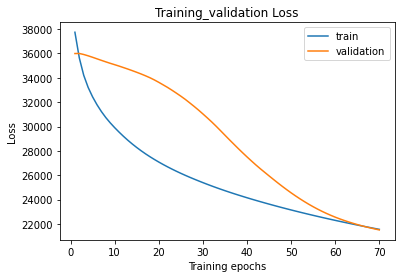

In [25]:
num_epochs = params_train['num_epochs']
plt.title('Training_validation Loss')
plt.plot(range(1,num_epochs+1), loss_hist['training'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['validation'], label ='validation')
plt.ylabel('Loss')
plt.xlabel('Training epochs')
plt.legend()
plt.show()

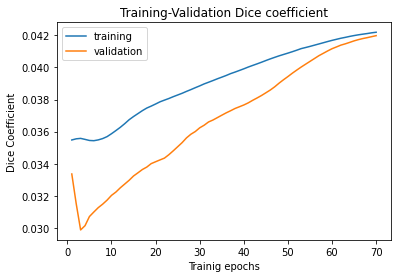

In [26]:
plt.title('Training-Validation Dice coefficient')
plt.plot(range(1, num_epochs+1), metric_his['training'], label='training')
plt.plot(range(1, num_epochs+1), metric_his['validation'], label = 'validation')
plt.ylabel('Dice Coefficient')
plt.xlabel('Trainig epochs')
plt.legend()
plt.show()


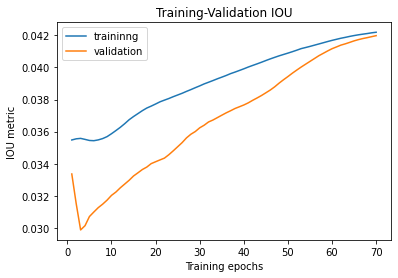

In [27]:
plt.title('Training-Validation IOU')
plt.plot(range(1,num_epochs+1), iou_his['training'], label='traininng')
plt.plot(range(1, num_epochs+1), iou_his['validation'], label ='validation')
plt.ylabel('IOU metric')
plt.xlabel('Training epochs')
plt.legend()
plt.show()

**Qualitative Results**

In [28]:
image_1, mask_1 = Val_data[77]
image_2, mask_2 = Val_data[54]
image_3, mask_3 = Val_data[11]
image_4, mask_4 = Val_data[96]

In [38]:
def get_pred(image):
  image = torch.unsqueeze(image,0)
  prediction = model(image)
  prediction = torch.nn.functional.softmax(prediction, dim=1)
  prediction = torch.squeeze(prediction)
  prediction = torch.argmax(prediction, dim=0)
  return prediction

**Image 1**

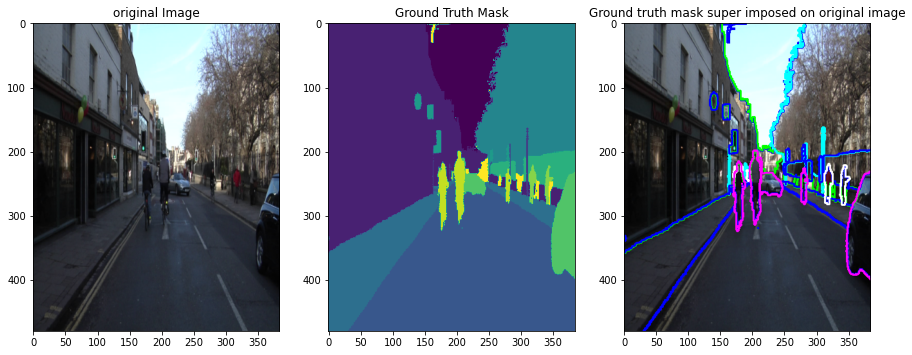

In [39]:
pred_1 = get_pred(image_1)
plt.figure(figsize=(15,15))
img_r = re_normalize(image_1)
plt.subplot(1, 3, 1)
plt.title('original Image')
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2)
plt.title('Ground Truth Mask')
plt.imshow(mask_1)
plt.subplot(1, 3, 3)
plt.title('Ground truth mask super imposed on original image')
show_img(img_r, mask_1)

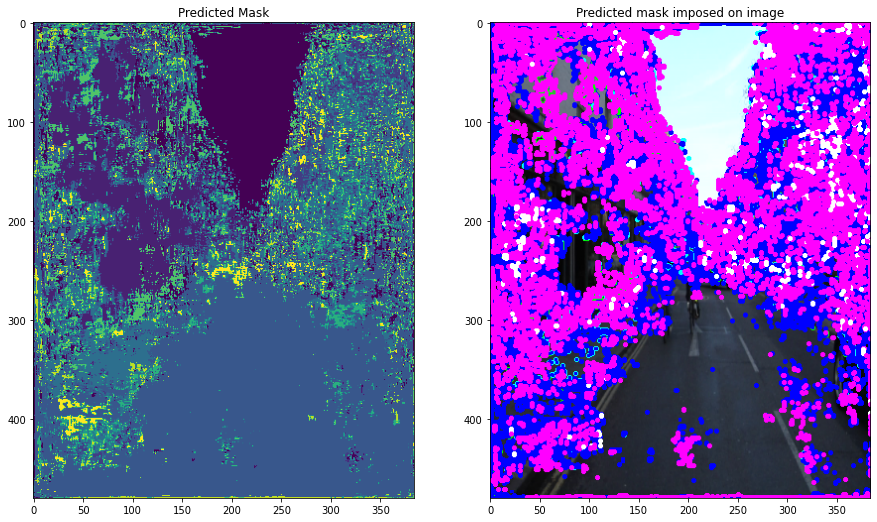

In [32]:
plt.figure(figsize = (15, 15))
plt.subplot(1, 2, 1)
plt.title('Predicted Mask')
plt.imshow(pred_1)
plt.subplot(1, 2, 2)
plt.title('Predicted mask imposed on image')
show_img(img_r, pred_1)

**Image 2**

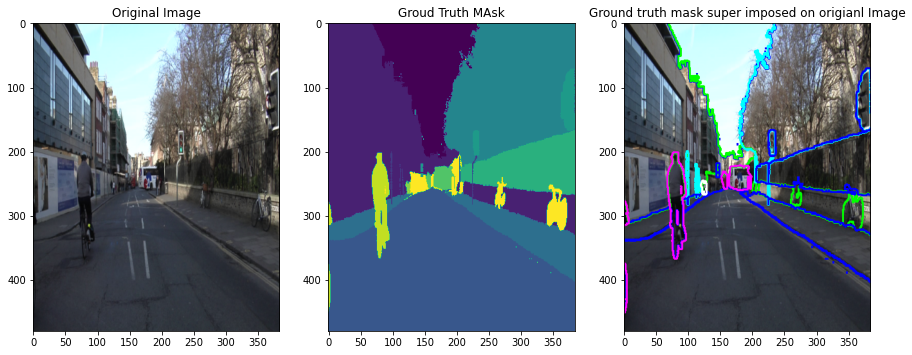

In [33]:
pred_2 =get_pred(image_2)
plt.figure(figsize=(15,15))
img_r = re_normalize(image_2)
plt.subplot(1,3,1)
plt.title('Original Image')
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2)
plt.title('Groud Truth MAsk')
plt.imshow(mask_2)
plt.subplot(1, 3, 3)
plt.title('Ground truth mask super imposed on origianl Image')
show_img(img_r, mask_2)

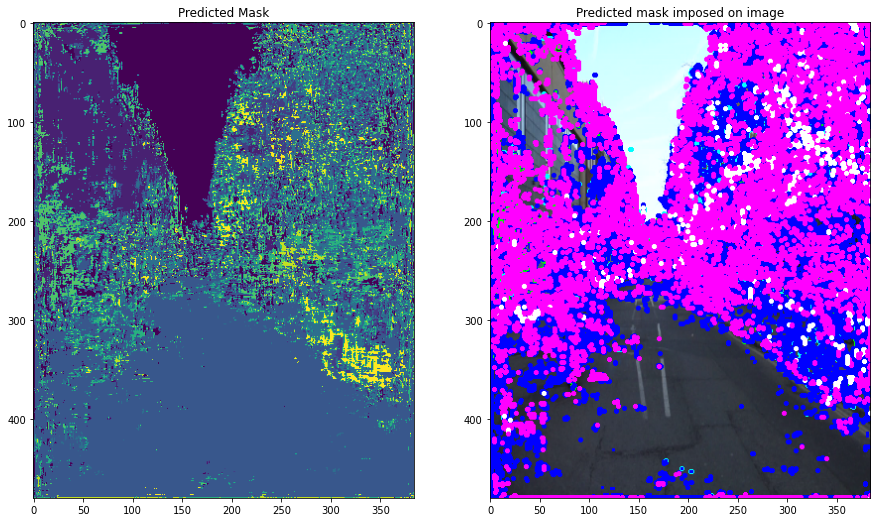

In [34]:
plt.figure(figsize = (15, 15))
plt.subplot(1, 2, 1)
plt.title('Predicted Mask')
plt.imshow(pred_2)
plt.subplot(1, 2, 2)
plt.title('Predicted mask imposed on image')
show_img(img_r, pred_2)

**Image 3**

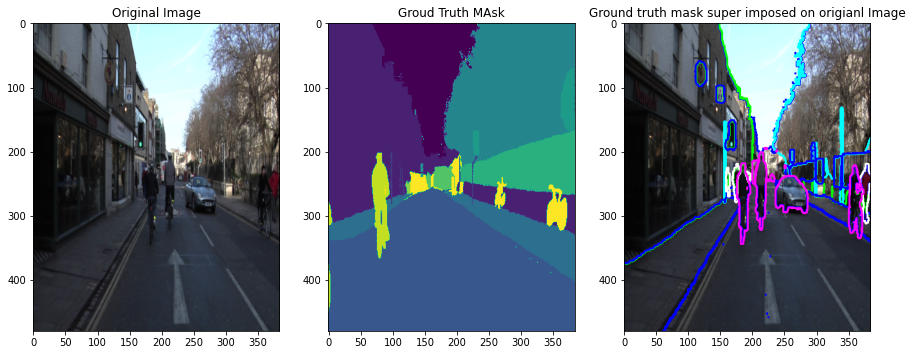

In [35]:
pred_3 =get_pred(image_3)
plt.figure(figsize=(15,15))
img_r = re_normalize(image_3)
plt.subplot(1,3,1)
plt.title('Original Image')
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2)
plt.title('Groud Truth MAsk')
plt.imshow(mask_2)
plt.subplot(1, 3, 3)
plt.title('Ground truth mask super imposed on origianl Image')
show_img(img_r, mask_3)

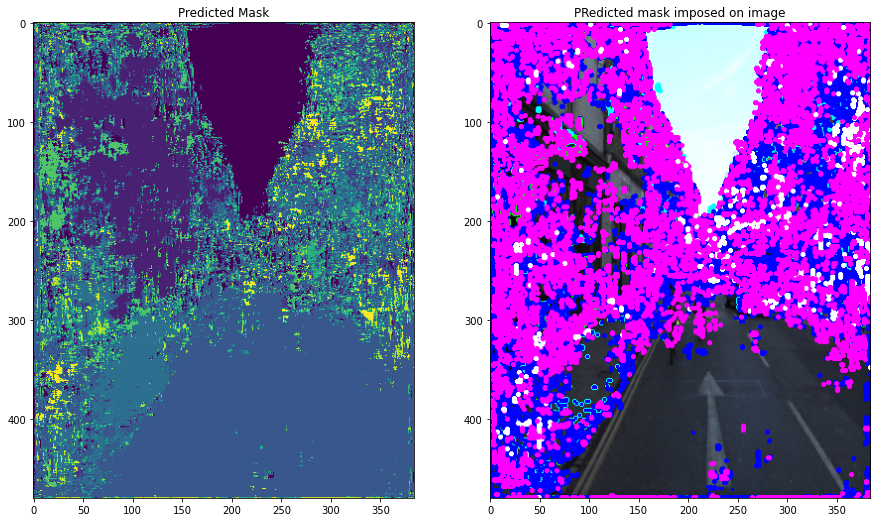

In [36]:
plt.figure(figsize = (15, 15))
plt.subplot(1, 2, 1)
plt.title('Predicted Mask')
plt.imshow(pred_3)
plt.subplot(1, 2, 2)
plt.title('PRedicted mask imposed on image')
show_img(img_r, pred_3)

**Image 4**

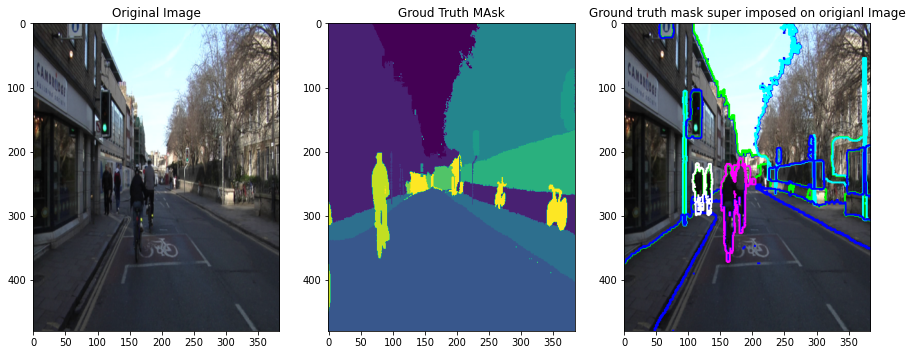

In [37]:
pred_4 =get_pred(image_4)
plt.figure(figsize=(15,15))
img_r = re_normalize(image_4)
plt.subplot(1,3,1)
plt.title('Original Image')
plt.imshow(to_pil_image(img_r))
plt.subplot(1, 3, 2)
plt.title('Groud Truth MAsk')
plt.imshow(mask_2)
plt.subplot(1, 3, 3)
plt.title('Ground truth mask super imposed on origianl Image')
show_img(img_r, mask_4)

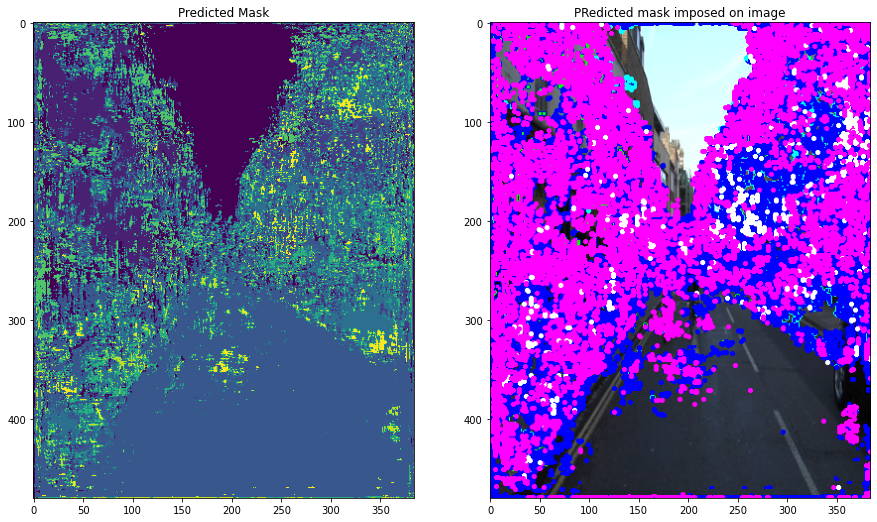

In [40]:
plt.figure(figsize = (15, 15))
plt.subplot(1, 2, 1)
plt.title('Predicted Mask')
plt.imshow(pred_4)
plt.subplot(1, 2, 2)
plt.title('PRedicted mask imposed on image')
show_img(img_r, pred_4)